In [1]:
import pandas as pd
import math
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import mean, std
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#ucitavanje i pregled podataka
data = pd.read_csv('/content/gdrive/MyDrive/Life Expectancy Data.csv')
data.head()


Mounted at /content/gdrive


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
def checkMissingValues(data):
    print("Broj nedostajucih vrednosti u celom data-setu je: ", data.isnull().sum().sum())
    print("Obelezja koja imaju nedostajuce vrednosti sa njihovim brojem su:")
    for i in range(1, data.shape[1]):
        if data.iloc[:,i].isnull().sum() > 0:
            print("\t\tBroj nedostajucih vrednosti za obelezje", data.columns[i], " je: ", data.iloc[:,i].isnull().sum())


In [4]:
def resolvingMissingValues(data):
    #vise od 30% uzorka fali => brise se uzorak
    beforeDropna = data.shape[0]
    #Keep only the rows with at least 30% non-NA values.
    data.dropna(thresh = data.shape[1] - math.ceil(((data.shape[1] - 1)*30)/100),axis = 0, inplace = True)
    print("Broj izbacenih uzoraka je: ", beforeDropna - data.shape[0])
    
    #uzorak ima nedostajacu vrednost za obelezje koje se predvidja => brise se uzorak
    data.dropna(subset = ['Life expectancy '], inplace = True, axis = 0)
    
    #provera da li se konzumacija alkohola razlikuje po regijama
    groupCountries = data.groupby(data['Country']).mean()
    groupCountries = groupCountries.sort_values(by=['Alcohol'])
    groupCountriesAlc = groupCountries['Alcohol'] 
    
    #popunjavanje nedostajucih vrednosti za alkohol 
    #South Sudan nema ni jedna njegova instanca nema vrednost za alkohol - dobija srednju vrednost celokupnog dataset-a
    data.loc[data['Country'] == 'South Sudan', "Alcohol"] = data.loc[data['Country'] == 'South Sudan', "Alcohol"].fillna(data['Alcohol'].median())
    data['Alcohol'] = data.groupby(data['Country'])['Alcohol'].apply(lambda x: x.fillna(x.median()))
    
    #provera hepatitisa po zemljama
    groupCountries = groupCountries.sort_values(by=['Hepatitis B'])
    groupCountriesHep = groupCountries['Hepatitis B']
    
    #provera hepatitisa po statusu - odnosno grupisanje razvijenih zemalja i zemlja u razvoju
    groupStatus = data.groupby(data['Status']).mean()
    groupStatus = groupStatus.sort_values(by=['Hepatitis B'])
    
    #nedostajuce vrednosti za obelezje hepatitis B ce biti popunjna medijanom statusa kojem pripadaju
    data['Hepatitis B'] = data.groupby(data['Status'])['Hepatitis B'].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za obelezje BMI ce biti popunjeno medijanom svih uzoraka
    data[' BMI '].fillna(data[' BMI '].median(), inplace = True)
    
    #nedostajuce vrednosti za polio - po statusu
    data['Polio'] = data.groupby(data['Status'])['Polio'].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za total expenditure
    data['Total expenditure'] = data.groupby(data['Country'])['Total expenditure'].apply(lambda x: x.fillna(x.median()))
    data['Total expenditure'] = data.groupby(data['Status'])['Total expenditure'].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za Diphtheria
    data['Diphtheria '] = data.groupby(data['Status'])['Diphtheria '].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za GDP
    #prvo one koje imaju neke vrednsoti za ovo obelezje za bilo koji uzorak koji pripada toj zemlji
    data['GDP'] = data.groupby(data['Country'])['GDP'].apply(lambda x: x.fillna(x.median()))
    #ostale po statusu
    data['GDP'] = data.groupby(data['Status'])['GDP'].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za Population
    data['Population'] = data.groupby(data['Country'])['Population'].apply(lambda x: x.fillna(x.median()))
    data['Population'].fillna(data['Population'].median(), inplace = True)
    
    #nedostajuce vrednosti za thinnes 10-19
    data[' thinness  1-19 years'].fillna(data[' thinness  1-19 years'].median(), inplace = True)

    #nedostajuce vrednosti za thinnes 5-9
    data[' thinness 5-9 years'].fillna(data[' thinness 5-9 years'].median(), inplace = True)
    
    #nedostajuce vrednosti za Income composition of resources
    data['Income composition of resources'] = data.groupby(data['Status'])['Income composition of resources'].apply(lambda x: x.fillna(x.median()))
    
    #nedostajuce vrednosti za schooling
    data['Schooling'] = data.groupby(data['Status'])['Schooling'].apply(lambda x: x.fillna(x.median()))


In [5]:
def catToNum(data):    
    #kat --> num za Status
    groupStatus = data.groupby(data['Status']).mean()
    groupStatus = groupStatus.sort_values(by=['Life expectancy '])    
    data.loc[data['Status'] == groupStatus.index[0], 'Status'] = 0
    data.loc[data['Status'] == groupStatus.index[1], 'Status'] = 1
    data['Status'] = data['Status'].astype(int)  
    
    #kat --> num za Country
    groupCountry = data.groupby(data['Country']).mean()
    groupCountry = groupCountry.sort_values(by=['Life expectancy '])
    for i in range(0, groupCountry.shape[0]):
        data.loc[data['Country'] == groupCountry.index[i], 'Country'] = i
    data['Country'] = data['Country'].astype(int) 

In [10]:
def dataSetAnalises(data): 
    #correlation - correlation matrix
    plt.figure(figsize= (16,6))
    mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
    heatmap = sb.heatmap(data.corr(), mask = mask, vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')
    heatmap.set_title('Korelacija', fontdict = {'fontsize':18}, pad = 16)
    
    #correlation - Life expectancy with other numerical characteristics
    for j in range(1, data.shape[1]):
        if data.columns[j] != 'Life expectancy ':
            plt.figure()
            plt.scatter(data.iloc[:, j], data['Life expectancy '], color = 'blue')
            plt.ylabel(data.columns[j])
            plt.xlabel('Life expectancy')
    
    #correlation - Life expectancy with categorical indicator Status
    dfStatus = data.set_index('Status')
    statusValues = dfStatus.index.unique()
    plt.figure(figsize=(10, 5))
    plt.boxplot([dfStatus.loc['Developing', 'Life expectancy '], dfStatus.loc['Developed', 'Life expectancy ']])
    plt.ylabel('Life expectancy')
    plt.xlabel('Country status')
    plt.xticks([1, 2], ['Developing', 'Developed'])
    plt.grid()

Broj nedostajucih vrednosti u celom data-setu je:  0
Obelezja koja imaju nedostajuce vrednosti sa njihovim brojem su:
Broj izbacenih uzoraka je:  0


<ipython-input-10-5e26bd9c915b>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
<ipython-input-10-5e26bd9c915b>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-10-5e26bd9c915b>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume

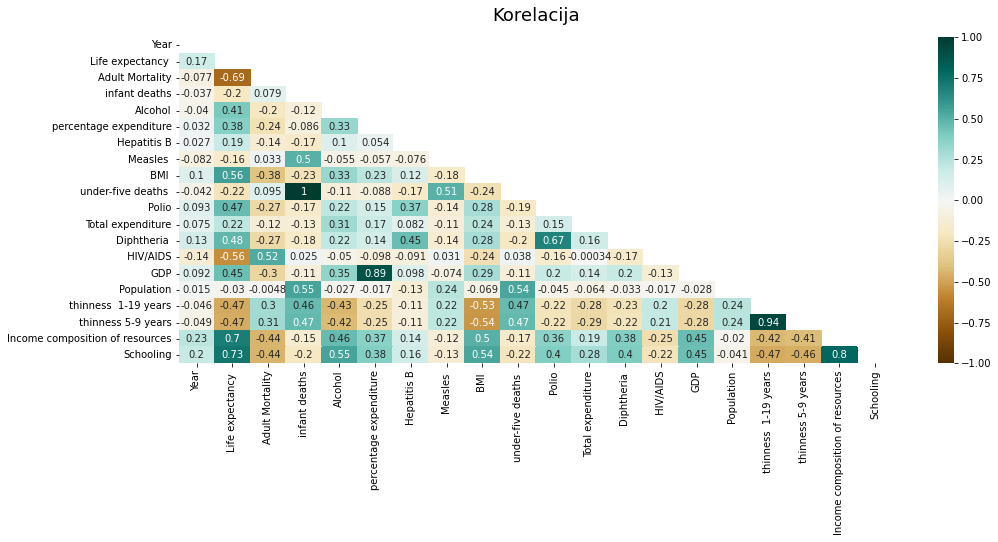

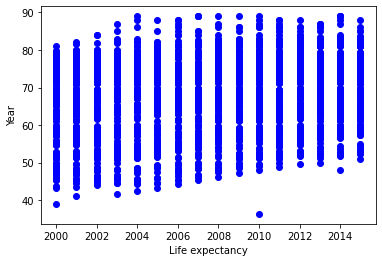

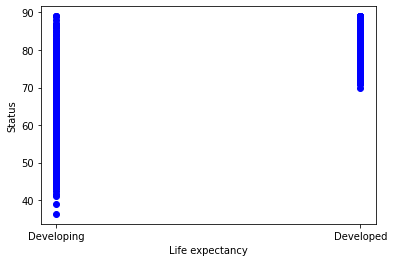

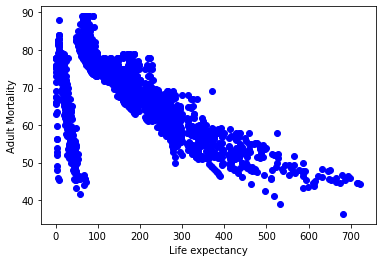

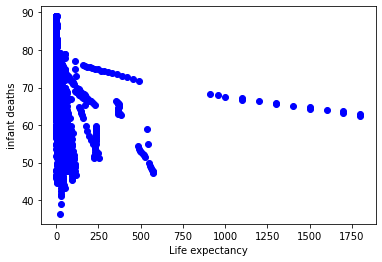

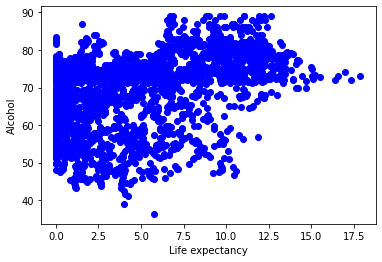

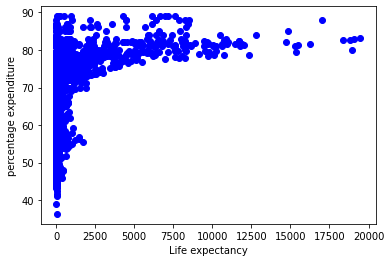

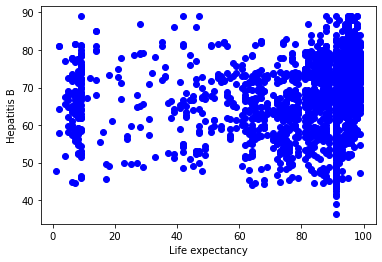

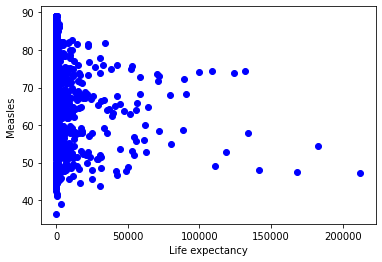

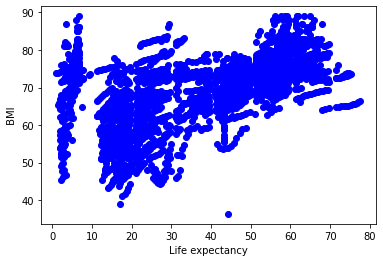

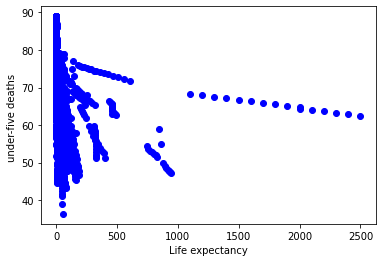

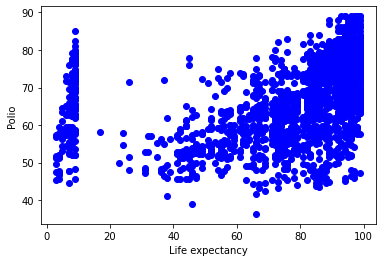

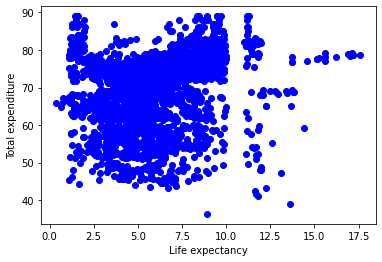

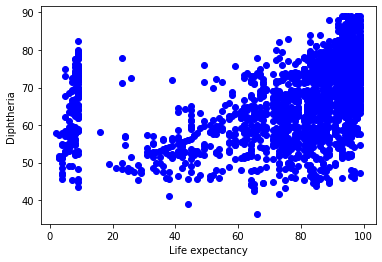

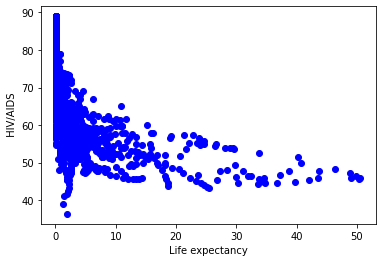

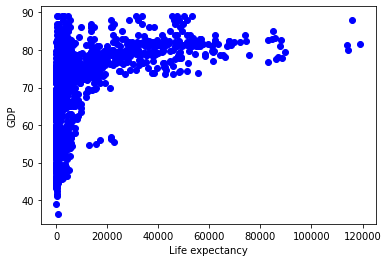

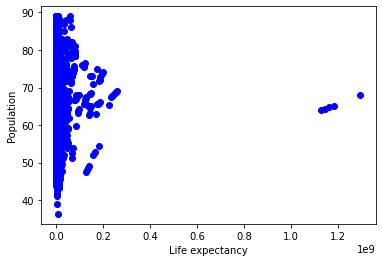

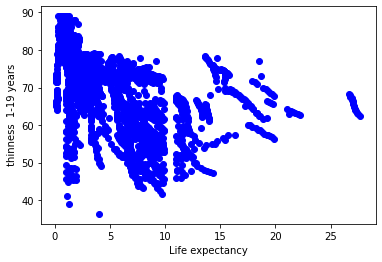

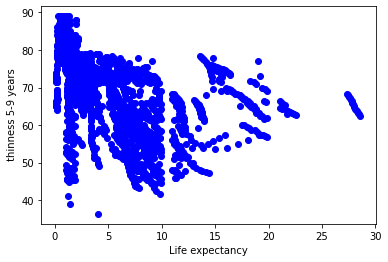

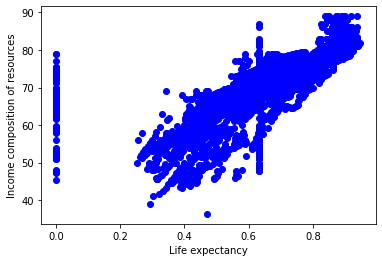

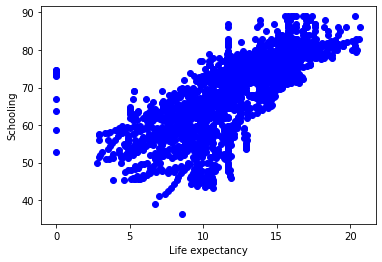

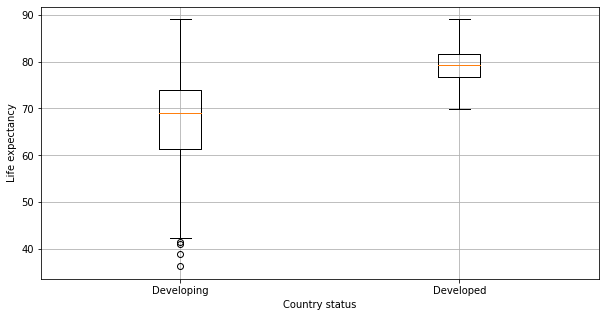

In [11]:
checkMissingValues(data)
resolvingMissingValues(data)
dataSetAnalises(data)
catToNum(data)

In [15]:
def modelEvaluation(y_test, y_predicted,N, d):
    mse = mean_squared_error(y_test, y_predicted) 
    mae = mean_absolute_error(y_test, y_predicted) 
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)
    rss = np.sum((y_test-y_predicted)**2)
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)
    print('RSS', rss)
    res=pd.concat([pd.DataFrame(y_test .values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return r2

In [12]:
X = data.drop(['Life expectancy '], axis = 1)
y = data['Life expectancy ']

In [13]:
def linRegression(X, y):
   kf = KFold(n_splits = 10)
   indexes = kf.split(X, y)
   r2 = 0
   for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       reg = LinearRegression()
       reg.fit(X_train, y_train)
       y_predicted = reg.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
   print('Average r2 is: ', r2/10)
   plt.figure(figsize=(10,5))
   plt.bar(range(len(reg.coef_)),  reg.coef_)
   print("Coefficients: ", reg.coef_)

Mean squared error:  5.606991138960834
Mean absolute error:  1.8981043493461265
Root mean squared error:  2.3679086002126084
R2 score:  0.9230155129003027
R2 adjusted score:  0.9223944317519763
RSS 1637.2414125765636
       y     y_pred
0   65.0  61.552810
1   59.9  61.751944
2   59.9  61.560704
3   59.5  61.244199
4   59.2  60.933587
5   58.8  60.417457
6   58.6  60.016286
7   58.1  59.836101
8   57.5  59.630724
9   57.3  59.063996
10  57.3  58.644968
11  57.0  56.817294
12  56.7  57.326301
13  56.2  56.493574
14  55.3  56.567898
15  54.8  55.956754
16  77.8  79.604753
17  77.5  79.566739
18  77.2  79.046937
19  76.9  78.797908
Mean squared error:  7.375493285812641
Mean absolute error:  2.2579757295726797
Root mean squared error:  2.715785942561129
R2 score:  0.940835493689123
R2 adjusted score:  0.9403581772724774
RSS 2153.644039457291
       y     y_pred
0   68.3  66.128884
1   67.9  65.406753
2   67.4  65.136779
3   67.0  64.800745
4   66.5  64.515759
5   65.8  64.218740
6   65.0 

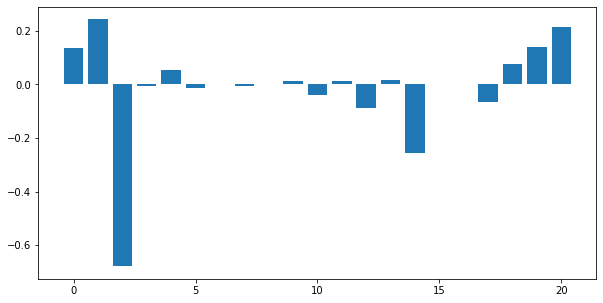

In [16]:
linRegression(X, y)

In [17]:
def polyFeat(X, degree):
    #degree default == 2
    if degree == 2:
        poly = PolynomialFeatures(degree = degree,interaction_only=True, include_bias=False)
    else:
        poly = PolynomialFeatures(degree = degree,interaction_only=False, include_bias=False)
    X = poly.fit_transform(X)
    return X

In [18]:
def interLinRegression(X, y, degree):
   X = polyFeat(X, degree)
   kf = KFold(n_splits = 10)
   indexes = kf.split(X, y)
   r2 = 0
   for train_index, test_index in indexes:
       X_train, X_test = X[train_index, :], X[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       reg = LinearRegression()
       reg.fit(X_train, y_train)
       y_predicted = reg.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
   print('Prosecni r2 je: ', r2/10)
   plt.figure(figsize=(10,5))
   plt.bar(range(len(reg.coef_)),  reg.coef_)
   print("koeficijenti: ", reg.coef_)

Mean squared error:  4.688010205653631
Mean absolute error:  1.5420558552304493
Root mean squared error:  2.1651813332036722
R2 score:  0.9356332028612268
R2 adjusted score:  0.9294197761420222
RSS 1368.8989800508602
       y     y_pred
0   65.0  63.081082
1   59.9  61.611679
2   59.9  62.570048
3   59.5  60.768421
4   59.2  60.633326
5   58.8  59.170206
6   58.6  58.172388
7   58.1  58.452001
8   57.5  59.832372
9   57.3  57.690771
10  57.3  56.058270
11  57.0  54.696752
12  56.7  53.865850
13  56.2  64.186383
14  55.3  54.537140
15  54.8  53.645788
16  77.8  78.176017
17  77.5  77.390108
18  77.2  77.824818
19  76.9  77.646755
Mean squared error:  8.806053487357591
Mean absolute error:  2.0870207608659697
Root mean squared error:  2.9674995345168282
R2 score:  0.9293598696471075
R2 adjusted score:  0.9225408683468491
RSS 2571.3676183084167
       y     y_pred
0   68.3  67.853788
1   67.9  61.228149
2   67.4  60.433959
3   67.0  60.212068
4   66.5  60.004073
5   65.8  59.808475
6   65

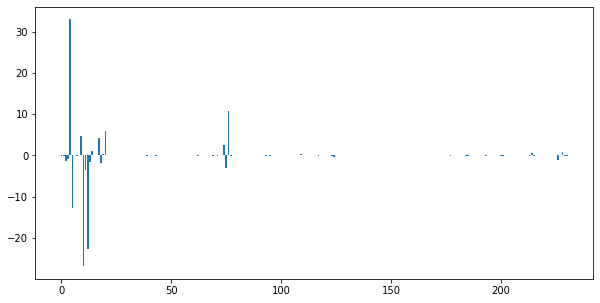

In [19]:
interLinRegression(X, y, 2)

In [20]:
def ridgeLinRegression(X, y, alpha):
   kf = KFold(n_splits = 10)
   indexes = kf.split(X, y)
   r2 = 0
   for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       reg = Ridge(alpha, solver = 'auto')
       reg.fit(X_train, y_train)
       y_predicted = reg.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
   print('Prosecni r2 je: ', r2/10)
   plt.figure(figsize=(10,5))
   plt.bar(range(len(reg.coef_)),  reg.coef_)
   print("koeficijenti: ", reg.coef_)

In [21]:
parameters = {'alpha': [1, 2, 3, 4, 5, 6, 7], 'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga')}
r = Ridge()
clf = GridSearchCV(r, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.46026e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.20141e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.62287e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.01097e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

0.9236088439490147
{'alpha': 7, 'solver': 'auto'}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.83132e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.65722e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.33034e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.57743e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.12826e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

Mean squared error:  5.59858814097803
Mean absolute error:  1.8970427243451355
Root mean squared error:  2.3661335847703167
R2 score:  0.9231308868100832
R2 adjusted score:  0.9225107364539601
RSS 1634.7877371655845
       y     y_pred
0   65.0  61.556211
1   59.9  61.755713
2   59.9  61.564484
3   59.5  61.247762
4   59.2  60.937495
5   58.8  60.420519
6   58.6  60.019342
7   58.1  59.839461
8   57.5  59.635057
9   57.3  59.067736
10  57.3  58.647995
11  57.0  56.818229
12  56.7  57.328482
13  56.2  56.499313
14  55.3  56.569632
15  54.8  55.957751
16  77.8  79.598254
17  77.5  79.560063
18  77.2  79.040076
19  76.9  78.790721
Mean squared error:  7.3668743663165
Mean absolute error:  2.2556446117410363
Root mean squared error:  2.71419866006829
R2 score:  0.9409046326737525
R2 adjusted score:  0.9404278740437674
RSS 2151.127314964418
       y     y_pred
0   68.3  66.133608
1   67.9  65.445940
2   67.4  65.175640
3   67.0  64.838272
4   66.5  64.552734
5   65.8  64.254990
6   65.0  63

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.21052e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Mean squared error:  6.118439741768768
Mean absolute error:  1.822052065877745
Root mean squared error:  2.4735480067645277
R2 score:  0.9292269319099051
R2 adjusted score:  0.9286561813607914
RSS 1780.4659648547113
       y     y_pred
0   71.9  69.646629
1   71.8  69.434397
2   71.6  69.396580
3   71.2  71.753248
4   71.1  70.345703
5   71.0  70.542218
6   78.0  69.746663
7   76.0  69.126015
8   74.0  68.493664
9   71.0  67.584293
10  69.9  67.563201
11  69.7  67.849570
12  69.6  68.658558
13  69.5  68.199811
14  69.4  68.847666
15  69.3  67.903089
16  69.2  67.959472
17  69.1  66.958632
18  69.1  64.489559
19  75.3  78.736645
Prosecni r2 je:  0.9202477154280084
koeficijenti:  [ 1.36994726e-01  2.42727850e-01 -6.54490174e-01 -4.54198464e-03
  5.21034925e-02 -1.49643100e-02  2.14786816e-04 -7.66794135e-03
 -1.44282908e-05  1.08479740e-02 -3.88748286e-02  1.20140455e-02
 -8.82491191e-02  1.78964168e-02 -2.55630095e-01 -4.37483529e-05
  9.40320362e-10 -6.47365296e-02  7.55678176e-02  1.1

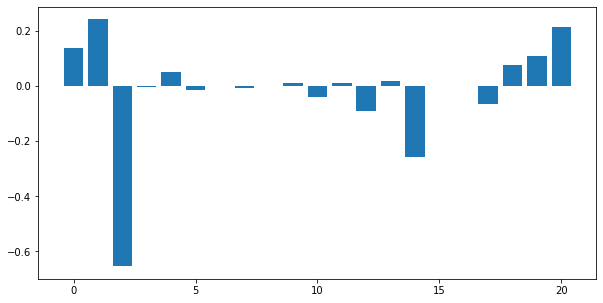

In [22]:
ridgeLinRegression(X, y, 7)

In [23]:
def lassoRegression(X, y, alpha):
   kf = KFold(n_splits = 10)
   indexes = kf.split(X, y)
   r2 = 0
   for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       reg = Lasso(alpha)
       reg.fit(X_train, y_train)
       y_predicted = reg.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
   print('Prosecni r2 je: ', r2/10)
   plt.figure(figsize=(10,5))
   plt.bar(range(len(reg.coef_)),  reg.coef_)
   print("koeficijenti: ", reg.coef_)

In [24]:
parameters = {'alpha': [0.005, 0.003, 0.001, 0]}
r = Lasso()
clf = GridSearchCV(r, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.724e+03, tolerance: 1.992e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.770e+03, tolerance: 2.149e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.487e+01, tolerance: 2.144e+01

0.9250374506375543
{'alpha': 0.005}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.549e+03, tolerance: 2.624e+01
  model = cd_fast.enet_coordinate_descent(


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.754e+03, tolerance: 2.398e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.542e+03, tolerance: 2.213e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.847e+03, tolerance: 2.408e+01

Mean squared error:  5.577439145862212
Mean absolute error:  1.8943073357275124
Root mean squared error:  2.361660251996932
R2 score:  0.9234212643943015
R2 adjusted score:  0.9228034566925267
RSS 1628.6122305917659
       y     y_pred
0   65.0  61.565231
1   59.9  61.764871
2   59.9  61.573924
3   59.5  61.256334
4   59.2  60.946707
5   58.8  60.428767
6   58.6  60.027264
7   58.1  59.846887
8   57.5  59.643945
9   57.3  59.075504
10  57.3  58.654797
11  57.0  56.819102
12  56.7  57.332270
13  56.2  56.589717
14  55.3  56.572563
15  54.8  55.959113
16  77.8  79.588799
17  77.5  79.550260
18  77.2  79.029624
19  76.9  78.779701
Mean squared error:  7.334073029642692
Mean absolute error:  2.2488972465691384
Root mean squared error:  2.708149373583867
R2 score:  0.9411677574323873
R2 adjusted score:  0.9406931215914653
RSS 2141.549324655666
       y     y_pred
0   68.3  66.147421
1   67.9  65.612693
2   67.4  65.339717
3   67.0  64.997628
4   66.5  64.708284
5   65.8  64.406375
6   65.0 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.484e+03, tolerance: 2.366e+01
  model = cd_fast.enet_coordinate_descent(


Mean squared error:  7.375183656261328
Mean absolute error:  1.896196670593283
Root mean squared error:  2.715728936448063
R2 score:  0.916565580235734
R2 adjusted score:  0.9158924635184656
RSS 2153.553627628308
       y     y_pred
0   71.9  75.701992
1   71.2  75.613365
2   78.0  75.064196
3   78.0  74.809870
4   64.8  61.664602
5   64.2  61.443790
6   63.7  60.130626
7   63.3  59.583088
8   62.6  58.923350
9   61.8  58.384818
10  68.0  58.214970
11  59.8  57.485721
12  58.5  57.907929
13  57.2  56.130494
14  56.0  55.277324
15  55.0  53.967970
16  54.0  53.991753
17  53.2  53.227321
18  52.5  52.727396
19  51.2  51.724668
Mean squared error:  5.030245419039598
Mean absolute error:  1.5180859922308116
Root mean squared error:  2.242820862003829
R2 score:  0.9116288747478607
R2 adjusted score:  0.9109159305948469
RSS 1468.8316623595629
       y     y_pred
0   82.7  85.237697
1   82.5  81.545584
2   82.4  84.413008
3   82.5  84.193829
4   82.1  84.479495
5   81.8  83.546769
6   81.6  8

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.882e+03, tolerance: 2.338e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.737e+03, tolerance: 2.361e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.178e+03, tolerance: 2.392e+01

Mean squared error:  4.701746906323437
Mean absolute error:  1.5636025913958815
Root mean squared error:  2.1683511953379315
R2 score:  0.9511574360558266
R2 adjusted score:  0.9507633930889317
RSS 1372.9100966464434
       y     y_pred
0   75.0  75.818223
1   74.9  75.567010
2   74.7  75.502516
3   74.5  75.077755
4   74.4  74.493573
5   74.1  74.863834
6   73.9  74.315095
7   73.7  74.110486
8   73.5  74.321011
9   73.2  74.803273
10  73.0  73.492297
11  72.7  73.928395
12  53.7  54.552306
13  52.1  54.617341
14  52.1  53.488164
15  52.2  54.291361
16  52.3  55.693965
17  51.1  53.499305
18  49.4  51.107141
19  47.8  48.454710
Mean squared error:  7.561507577879483
Mean absolute error:  1.8990570386298036
Root mean squared error:  2.7498195536942935
R2 score:  0.9158331316126378
R2 adjusted score:  0.9151541057823902
RSS 2207.960212740809
       y     y_pred
0   71.4  69.271097
1   71.0  69.636213
2   77.0  69.322034
3   72.0  68.796837
4   69.9  69.104799
5   69.5  68.700026
6   69.

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.525e+03, tolerance: 2.333e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.694e+03, tolerance: 2.371e+01
  model = cd_fast.enet_coordinate_descent(


Mean squared error:  7.9573674679513875
Mean absolute error:  2.168484684846502
Root mean squared error:  2.8208806192307017
R2 score:  0.9202165510309787
R2 adjusted score:  0.9195731361199382
RSS 2315.5939331738537
       y     y_pred
0   73.0  72.769662
1   88.0  81.311781
2   87.0  81.710740
3   85.0  81.245397
4   82.0  80.782193
5   79.8  80.422299
6   79.5  80.179627
7   79.1  80.244134
8   78.9  80.017271
9   78.3  79.811654
10  78.1  79.511729
11  77.5  79.155037
12  77.2  78.803004
13  76.5  78.389330
14  76.6  77.907028
15  76.2  77.503385
16  76.0  77.226739
17  69.2  68.072381
18  68.8  68.262116
19  68.8  68.075227
Mean squared error:  6.114536213207983
Mean absolute error:  1.820886789315116
Root mean squared error:  2.472758826333046
R2 score:  0.9292720847109923
R2 adjusted score:  0.9287016982973713
RSS 1779.330038043523
       y     y_pred
0   71.9  69.638798
1   71.8  69.426189
2   71.6  69.389453
3   71.2  71.740253
4   71.1  70.323310
5   71.0  70.521639
6   78.0 

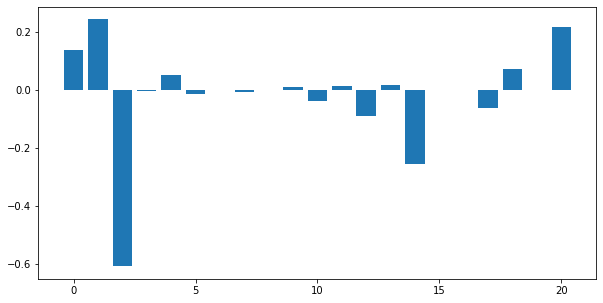

In [25]:
lassoRegression(X, y, 0.005)

In [26]:
parameters = {'criterion': ('mse', 'mae', 'friedman_mse'), 'max_depth': [5,10,15],  'min_samples_split':[0.01, 0.05]}
dt = DecisionTreeRegressor()
clf = GridSearchCV(dt, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: 

0.935000518030861
{'criterion': 'mse', 'max_depth': 10, 'min_samples_split': 0.05}


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [27]:
from sklearn import tree
def decisionTree(X, y):
    kf = KFold(n_splits = 10)
    indexes = kf.split(X,y)
    r2 = 0
    for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       dt = DecisionTreeRegressor(criterion = 'mse', max_depth = 10, min_samples_split = 0.05)
       dt.fit(X_train, y_train)
       y_predicted = dt.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
       plt.figure(figsize = (16, 9))
       tree.plot_tree(dt) 
    print('Prosecni r2 je: ', r2/10)
    

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  3.535987179208085
Mean absolute error:  1.3117171514780108
Root mean squared error:  1.8804220747502634
R2 score:  0.9514505814908616
R2 adjusted score:  0.9510589035082677
RSS 1032.5082563287608
       y     y_pred
0   65.0  64.042647
1   59.9  64.042647
2   59.9  64.042647
3   59.5  64.042647
4   59.2  62.387736
5   58.8  62.387736
6   58.6  62.387736
7   58.1  62.387736
8   57.5  62.387736
9   57.3  62.387736
10  57.3  62.387736
11  57.0  58.996429
12  56.7  58.996429
13  56.2  58.996429
14  55.3  58.996429
15  54.8  58.996429
16  77.8  76.489524
17  77.5  76.489524
18  77.2  76.489524
19  76.9  76.489524
Mean squared error:  5.055102817993328


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean absolute error:  1.5941944499426108
Root mean squared error:  2.2483555808620057
R2 score:  0.9594491309276075
R2 adjusted score:  0.9591219821567584
RSS 1476.0900228540518
       y     y_pred
0   68.3  66.973684
1   67.9  66.973684
2   67.4  66.973684
3   67.0  64.102564
4   66.5  64.102564
5   65.8  64.102564
6   65.0  64.102564
7   64.2  64.102564
8   63.3  64.102564
9   62.5  64.102564
10  61.7  64.102564
11  62.0  64.102564
12  77.0  69.380000
13  74.0  69.380000
14  71.0  69.380000
15  69.8  69.380000
16  69.3  69.380000
17  68.7  69.380000
18  68.0  69.380000
19  67.4  69.380000


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  4.009763884289265
Mean absolute error:  1.3639561669596911
Root mean squared error:  2.0024394833026204
R2 score:  0.9457477449726146
R2 adjusted score:  0.9453100587046257
RSS 1170.8510542124654
       y     y_pred
0   73.5  73.343541
1   73.1  73.343541
2   73.1  73.343541
3   72.8  73.343541
4   72.4  73.343541
5   71.8  73.343541
6   71.5  72.600000
7   71.4  73.343541
8   63.5  63.549107
9   63.2  63.549107
10  62.9  63.549107
11  62.5  63.549107
12  62.2  63.549107
13  61.8  63.549107
14  61.3  63.549107
15  61.0  63.549107
16  66.0  63.549107
17  63.0  63.549107
18  60.0  63.549107
19  59.8  59.064000


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  8.742007625405067
Mean absolute error:  1.955894924029041
Root mean squared error:  2.956688625033936
R2 score:  0.9011028921047635
R2 adjusted score:  0.9003050283837493
RSS 2552.66622661828
       y     y_pred
0   71.9  73.364198
1   71.2  73.364198
2   78.0  73.364198
3   78.0  73.364198
4   64.8  63.099065
5   64.2  63.099065
6   63.7  63.099065
7   63.3  63.099065
8   62.6  63.099065
9   61.8  63.099065
10  68.0  63.099065
11  59.8  63.099065
12  58.5  63.099065
13  57.2  56.179412
14  56.0  56.179412
15  55.0  56.179412
16  54.0  56.179412
17  53.2  56.179412
18  52.5  56.179412
19  51.2  56.179412


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  3.791776869777059
Mean absolute error:  1.3048915285357867
Root mean squared error:  1.9472485382654827
R2 score:  0.9333862345127468
R2 adjusted score:  0.932848820346311
RSS 1107.1988459749011
       y     y_pred
0   82.7  81.943333
1   82.5  81.943333
2   82.4  81.943333
3   82.5  81.943333
4   82.1  81.943333
5   81.8  81.943333
6   81.6  81.943333
7   81.4  81.943333
8   81.3  81.943333
9   81.1  81.943333
10  81.0  80.600000
11  88.0  80.600000
12  87.0  80.600000
13  84.0  80.600000
14  80.0  80.600000
15  79.7  80.600000
16  68.3  66.256667
17  68.0  66.256667
18  67.6  66.256667
19  67.3  66.256667


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  4.873569452190988
Mean absolute error:  1.4715106817841863
Root mean squared error:  2.207616237526574
R2 score:  0.9493725135896046
R2 adjusted score:  0.9489640705567124
RSS 1423.0822800397684
       y     y_pred
0   75.0  74.861321
1   74.9  74.861321
2   74.7  73.728947
3   74.5  73.728947
4   74.4  72.692857
5   74.1  73.728947
6   73.9  73.728947
7   73.7  73.728947
8   73.5  73.728947
9   73.2  73.728947
10  73.0  72.692857
11  72.7  73.728947
12  53.7  49.698438
13  52.1  49.698438
14  52.1  49.698438
15  52.2  49.698438
16  52.3  49.698438
17  51.1  49.698438
18  49.4  49.698438
19  47.8  49.698438


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  5.7639093675291475
Mean absolute error:  1.7413599166781484
Root mean squared error:  2.4008143134214164
R2 score:  0.9358421325196161
R2 adjusted score:  0.9353245315910383
RSS 1683.061535318511
       y     y_pred
0   71.4  72.037795
1   71.0  72.037795
2   77.0  72.037795
3   72.0  72.037795
4   69.9  72.037795
5   69.5  72.037795
6   69.0  72.037795
7   68.6  72.037795
8   57.6  57.018056
9   56.7  57.018056
10  55.3  57.018056
11  54.8  57.018056
12  54.3  57.018056
13  54.0  57.018056
14  53.8  57.018056
15  53.2  57.018056
16  52.1  55.016667
17  51.2  55.016667
18  58.0  53.067708
19  54.0  53.067708


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  5.093939959657654
Mean absolute error:  1.485406249971903
Root mean squared error:  2.256975843835652
R2 score:  0.933005152064962
R2 adjusted score:  0.9324648710332278
RSS 1482.3365282603772
       y     y_pred
0   74.7  75.314706
1   74.5  75.314706
2   74.2  75.314706
3   73.7  75.314706
4   81.1  84.187500
5   89.0  84.187500
6   86.0  84.187500
7   83.0  84.187500
8   82.0  84.187500
9   79.6  84.187500
10  79.3  81.794565
11  79.0  81.794565
12  78.7  81.794565
13  78.5  81.794565
14  77.7  77.274074
15  78.0  77.274074
16  77.3  77.274074
17  77.2  77.274074
18  76.9  77.274074
19  76.6  77.274074


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  8.36833754543652
Mean absolute error:  1.8940851319670506
Root mean squared error:  2.8928078998503373
R2 score:  0.9160960161509587
R2 adjusted score:  0.9154193711199181
RSS 2435.1862257220273
       y     y_pred
0   73.0  73.791597
1   88.0  83.609524
2   87.0  83.609524
3   85.0  83.609524
4   82.0  83.609524
5   79.8  83.609524
6   79.5  83.609524
7   79.1  81.412000
8   78.9  81.412000
9   78.3  81.412000
10  78.1  78.128571
11  77.5  78.128571
12  77.2  78.128571
13  76.5  78.128571
14  76.6  78.128571
15  76.2  78.128571
16  76.0  78.128571
17  69.2  69.751948
18  68.8  69.751948
19  68.8  69.751948


/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


Mean squared error:  5.567660884564577
Mean absolute error:  1.461948844299403
Root mean squared error:  2.359589134693703
R2 score:  0.93559788777589
R2 adjusted score:  0.935078515903115
RSS 1620.189317408292
       y     y_pred
0   71.9  71.941463
1   71.8  71.941463
2   71.6  71.941463
3   71.2  70.805556
4   71.1  70.805556
5   71.0  70.805556
6   78.0  70.805556
7   76.0  70.805556
8   74.0  70.805556
9   71.0  70.805556
10  69.9  71.177778
11  69.7  71.177778
12  69.6  71.177778
13  69.5  71.177778
14  69.4  71.177778
15  69.3  71.177778
16  69.2  71.177778
17  69.1  71.177778
18  69.1  71.177778
19  75.3  74.742017
Prosecni r2 je:  0.9361050286109626


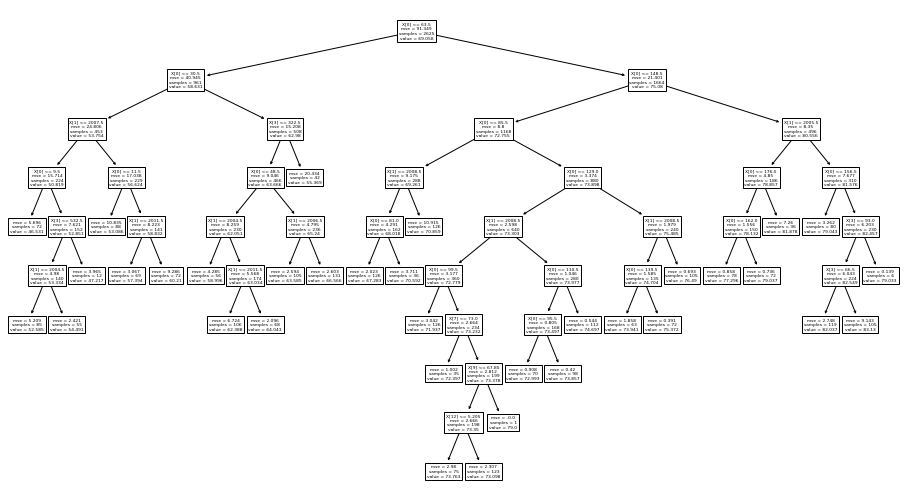

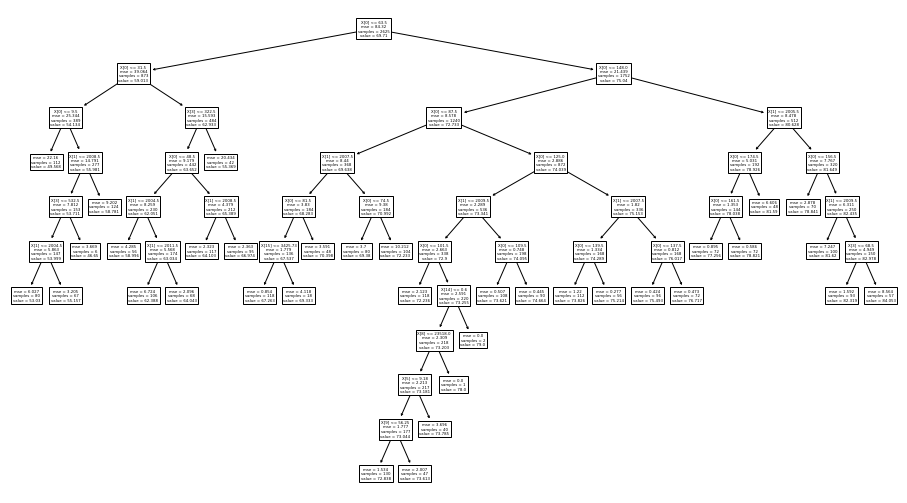

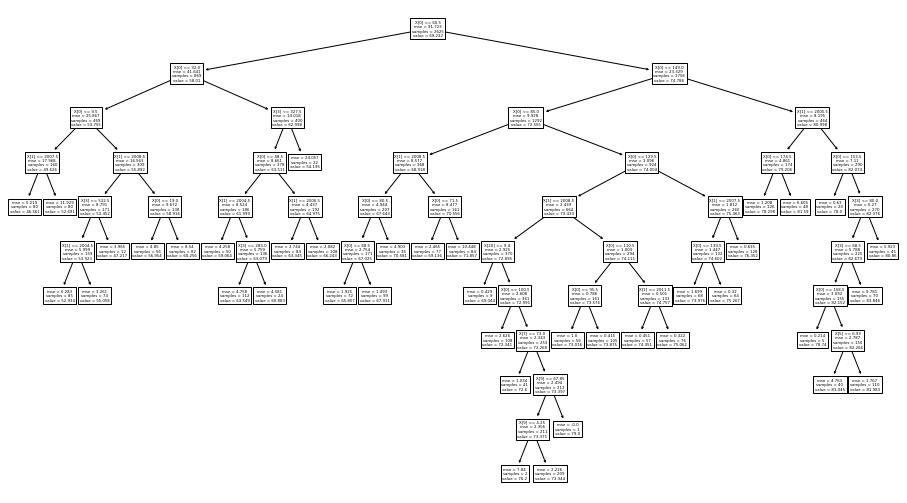

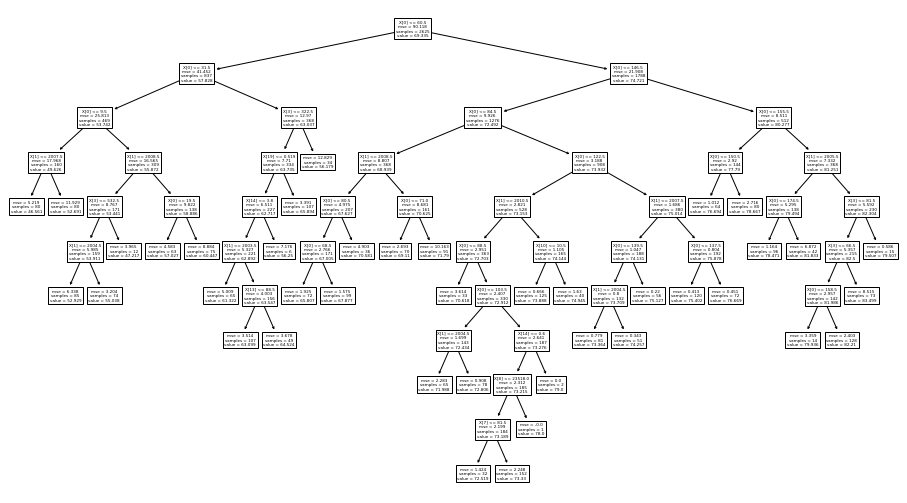

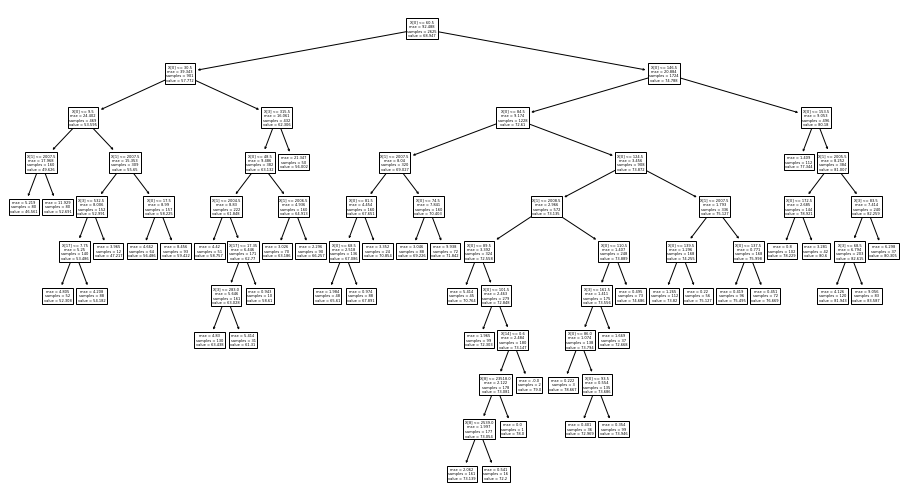

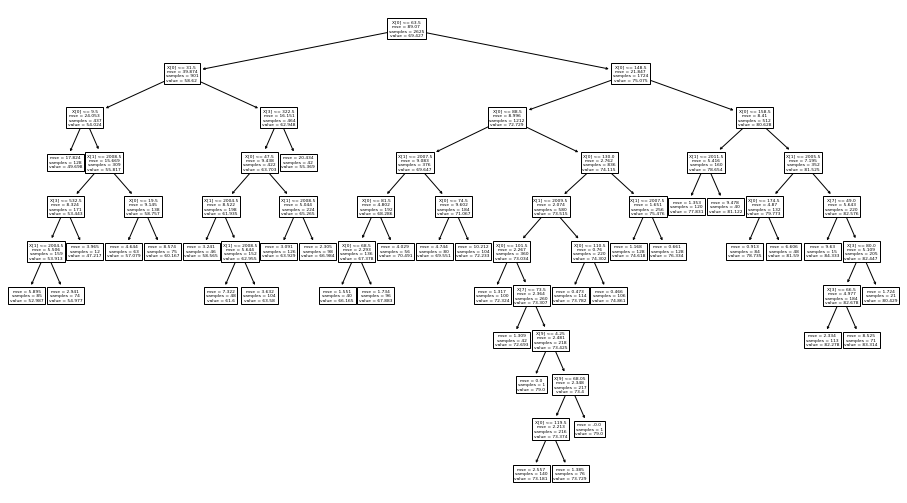

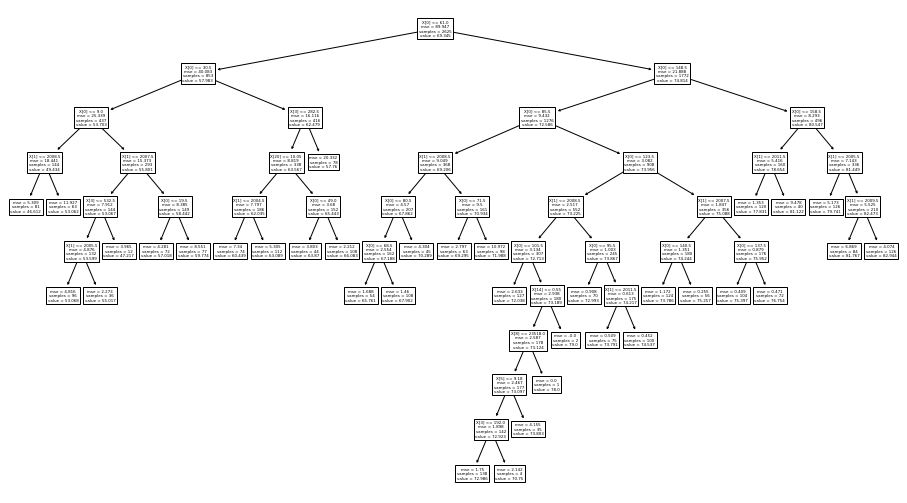

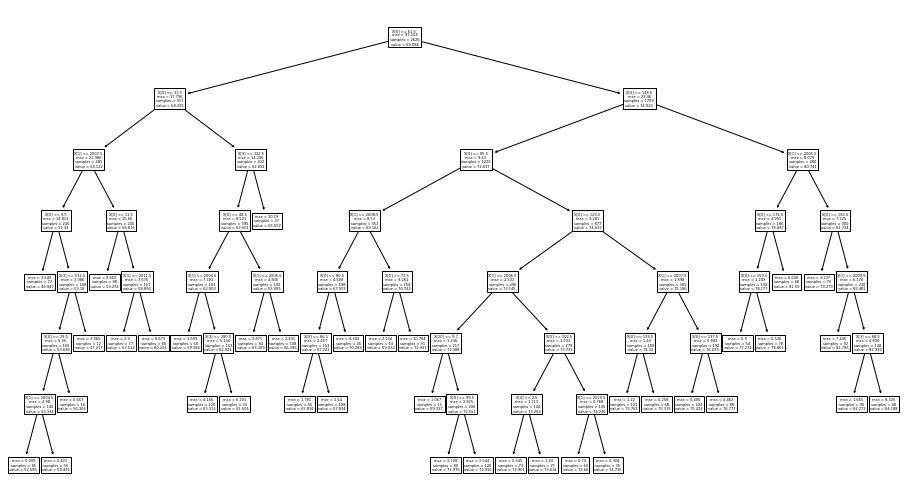

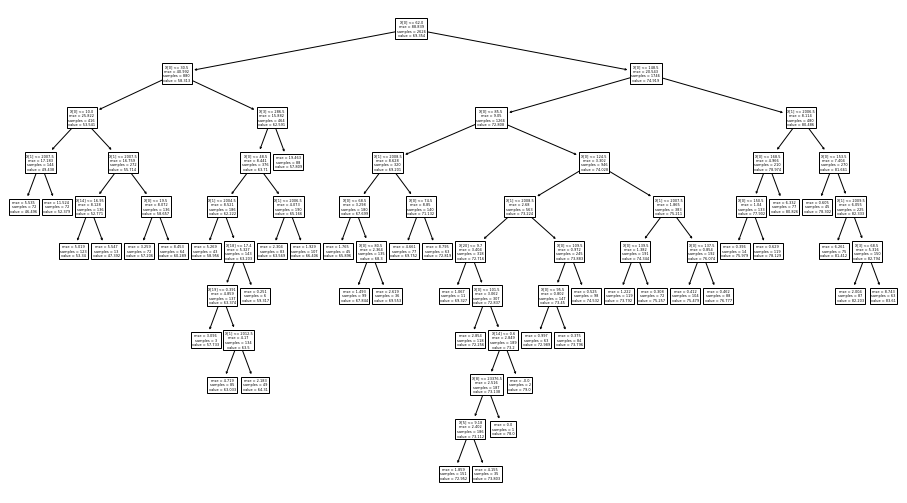

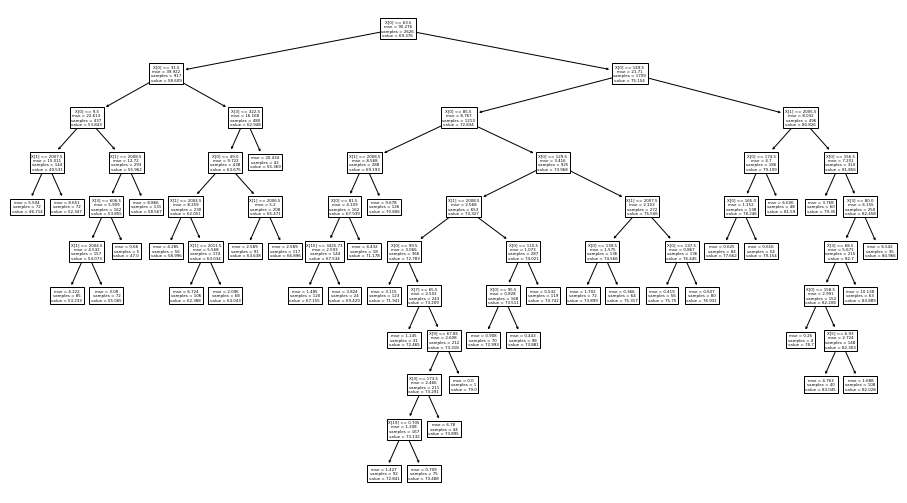

In [28]:
decisionTree(X, y)

In [ ]:
parameters = {'max_depth': [5,10],  'min_samples_split':[0.01, 0.05]}
dt = RandomForestRegressor()
clf = GridSearchCV(dt, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

0.9564705890951967
{'max_depth': 10, 'min_samples_split': 0.01}


In [29]:
def randomForest(X, y, criter, md, mss):
    kf = KFold(n_splits = 10)
    indexes = kf.split(X,y)
    r2 = 0
    for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       dt = RandomForestRegressor(criterion = criter, max_depth = md, min_samples_split = mss)
       dt.fit(X_train, y_train)
       y_predicted = dt.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])
       plt.figure(figsize = (16, 9))
    print('Prosecni r2 je: ', r2/10)

In [30]:
randomForest(X, y, 'mse', 10, 0.01)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  2.116762294839807
Mean absolute error:  0.9650540938151422
Root mean squared error:  1.4549097205118284
R2 score:  0.9709366653983295
R2 adjusted score:  0.970702193624747
RSS 618.0945900932236
       y     y_pred
0   65.0  63.727620
1   59.9  63.465689
2   59.9  63.456148
3   59.5  63.160158
4   59.2  62.871450
5   58.8  62.774618
6   58.6  62.618750
7   58.1  61.190577
8   57.5  59.817092
9   57.3  59.486266
10  57.3  58.816445
11  57.0  56.767627
12  56.7  56.471033
13  56.2  56.479937
14  55.3  56.028213
15  54.8  55.887653
16  77.8  77.125023
17  77.5  77.022263
18  77.2  77.066535
19  76.9  76.950891


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  2.861806458607646
Mean absolute error:  1.1602365712398548
Root mean squared error:  1.691687458902396
R2 score:  0.9770432485368137
R2 adjusted score:  0.9768580423206297
RSS 835.6474859134327
       y     y_pred
0   68.3  68.072398
1   67.9  67.252492
2   67.4  66.944767
3   67.0  65.942635
4   66.5  65.120250
5   65.8  64.338393
6   65.0  64.324680
7   64.2  64.174437
8   63.3  63.122559
9   62.5  62.678603
10  61.7  64.121550
11  62.0  62.601853
12  77.0  69.048356
13  74.0  69.043151
14  71.0  69.001157
15  69.8  68.805519
16  69.3  68.570198
17  68.7  69.050995
18  68.0  68.791313
19  67.4  67.793940


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  2.892247708055099
Mean absolute error:  1.1593524858993471
Root mean squared error:  1.7006609621129953
R2 score:  0.9608677805507272
R2 adjusted score:  0.9605520768978517
RSS 844.5363307520888
       y     y_pred
0   73.5  73.002975
1   73.1  72.726773
2   73.1  72.789359
3   72.8  72.561673
4   72.4  72.627191
5   71.8  72.655806
6   71.5  72.567299
7   71.4  72.643161
8   63.5  64.555025
9   63.2  64.689928
10  62.9  64.539011
11  62.5  64.276916
12  62.2  64.144053
13  61.8  63.933830
14  61.3  63.701153
15  61.0  63.410435
16  66.0  62.912018
17  63.0  62.833775
18  60.0  63.353000
19  59.8  60.899892


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  5.540058308876201
Mean absolute error:  1.394986237455306
Root mean squared error:  2.353732845689205
R2 score:  0.9373260962703125
R2 adjusted score:  0.9368204673888975
RSS 1617.6970261918507
       y     y_pred
0   71.9  73.390327
1   71.2  73.454083
2   78.0  73.599833
3   78.0  73.371835
4   64.8  62.440131
5   64.2  62.847694
6   63.7  62.474275
7   63.3  62.302207
8   62.6  61.566891
9   61.8  60.985840
10  68.0  60.514518
11  59.8  59.939935
12  58.5  59.913023
13  57.2  57.279496
14  56.0  56.583437
15  55.0  55.922623
16  54.0  55.401269
17  53.2  55.401269
18  52.5  55.298687
19  51.2  54.722592


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  3.310827193267688
Mean absolute error:  1.1728120200952448
Root mean squared error:  1.819567858934557
R2 score:  0.9418355367956761
R2 adjusted score:  0.9413662883410888
RSS 966.7615404341649
       y     y_pred
0   82.7  82.654347
1   82.5  82.451116
2   82.4  82.533909
3   82.5  82.519664
4   82.1  83.871201
5   81.8  82.894417
6   81.6  82.475251
7   81.4  82.520917
8   81.3  82.643270
9   81.1  82.654325
10  81.0  81.074683
11  88.0  80.713758
12  87.0  80.386926
13  84.0  80.344776
14  80.0  80.267756
15  79.7  80.333459
16  68.3  67.170000
17  68.0  66.995160
18  67.6  66.951369
19  67.3  66.966971


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  2.786673629697657
Mean absolute error:  1.1267381978533964
Root mean squared error:  1.6693332889802615
R2 score:  0.9710515500596181
R2 adjusted score:  0.9708180051311709
RSS 813.7086998717159
       y     y_pred
0   75.0  74.847571
1   74.9  74.682147
2   74.7  74.563895
3   74.5  74.081518
4   74.4  73.610485
5   74.1  73.609705
6   73.9  73.453243
7   73.7  73.320972
8   73.5  73.212926
9   73.2  73.231153
10  73.0  73.156524
11  72.7  73.361091
12  53.7  56.968439
13  52.1  56.894605
14  52.1  54.717790
15  52.2  52.367602
16  52.3  52.656829
17  51.1  51.612055
18  49.4  52.403031
19  47.8  50.252107


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  3.0790978594460006
Mean absolute error:  1.084870290285312
Root mean squared error:  1.7547358375111624
R2 score:  0.9657266726749115
R2 adjusted score:  0.9654501686895766
RSS 899.0965749582322
       y     y_pred
0   71.4  72.788972
1   71.0  72.120943
2   77.0  71.222969
3   72.0  70.855596
4   69.9  70.895564
5   69.5  70.810527
6   69.0  70.743333
7   68.6  70.785582
8   57.6  55.381352
9   56.7  55.913375
10  55.3  55.888121
11  54.8  54.831791
12  54.3  54.627943
13  54.0  54.422695
14  53.8  54.180910
15  53.2  53.661088
16  52.1  52.287431
17  51.2  51.803973
18  58.0  51.228663
19  54.0  50.527692


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  4.16007871294281
Mean absolute error:  1.2828514566226812
Root mean squared error:  2.0396271014434992
R2 score:  0.9452871759426621
R2 adjusted score:  0.9448459434905868
RSS 1210.5829054663577
       y     y_pred
0   74.7  75.048538
1   74.5  74.983272
2   74.2  74.919606
3   73.7  74.890827
4   81.1  83.023572
5   89.0  82.546401
6   86.0  82.231122
7   83.0  81.954873
8   82.0  81.371809
9   79.6  80.898146
10  79.3  80.145736
11  79.0  79.858814
12  78.7  79.645405
13  78.5  79.013955
14  77.7  78.235219
15  78.0  78.004088
16  77.3  77.780114
17  77.2  77.779652
18  76.9  77.715157
19  76.6  77.670279


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  5.565716519475068
Mean absolute error:  1.4937450153287768
Root mean squared error:  2.359177085230159
R2 score:  0.9441961098697509
R2 adjusted score:  0.9437460784977327
RSS 1619.623507167245
       y     y_pred
0   73.0  73.571203
1   88.0  82.220544
2   87.0  82.132513
3   85.0  81.615024
4   82.0  81.557250
5   79.8  80.936426
6   79.5  80.449674
7   79.1  80.314725
8   78.9  79.761671
9   78.3  79.421278
10  78.1  78.913811
11  77.5  78.392133
12  77.2  78.209249
13  76.5  77.805274
14  76.6  77.592605
15  76.2  77.438984
16  76.0  77.365078
17  69.2  70.575140
18  68.8  70.227652
19  68.8  69.779754


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Mean squared error:  5.28285512522974
Mean absolute error:  1.4120688122030578
Root mean squared error:  2.298446241535734
R2 score:  0.9388922860618211
R2 adjusted score:  0.9383994819171584
RSS 1537.3108414418543
       y     y_pred
0   71.9  71.995475
1   71.8  72.030183
2   71.6  72.014375
3   71.2  69.911137
4   71.1  71.916818
5   71.0  71.990282
6   78.0  71.911732
7   76.0  70.069150
8   74.0  69.072715
9   71.0  70.195121
10  69.9  71.115484
11  69.7  71.435885
12  69.6  71.701037
13  69.5  71.775119
14  69.4  71.936792
15  69.3  71.528091
16  69.2  71.752887
17  69.1  71.586290
18  69.1  71.429184
19  75.3  75.550201
Prosecni r2 je:  0.9553163122160621


<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [ ]:
parameters = {
    'hidden_layer_sizes': [(50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [500]
}
nn = MLPRegressor()
clf = GridSearchCV(nn, parameters)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

"\nparameters = {\n    'hidden_layer_sizes': [(50,50), (100,50)],\n    'activation': ['tanh', 'relu'],\n    'solver': ['sgd', 'adam'],\n    'alpha': [0.0001, 0.05],\n    'learning_rate': ['constant','adaptive'],\n    'max_iter': [500]\n}\nnn = MLPRegressor()\nclf = GridSearchCV(nn, parameters)\nclf.fit(X, y)\nprint(clf.best_score_)\nprint(clf.best_params_)\n"

In [ ]:
def nn(X, y):
    kf = KFold(n_splits = 10)
    indexes = kf.split(X,y)
    r2 = 0
    for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       dt = MLPRegressor(hidden_layer_sizes=(64,64,64), activation='tanh', max_iter = 500)
       dt.fit(X_train, y_train)
       y_predicted = dt.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1]) 
    print('Prosecni r2 je: ', r2/10)


In [ ]:
nn(X, y)

Mean squared error:  78.22828767041561
Mean absolute error:  7.192073083911565
Root mean squared error:  8.844675667904143
R2 score:  -0.07408134839868308
R2 adjusted score:  -0.08274662243493824
RSS 22842.65999976136
       y     y_pred
0   65.0  69.021694
1   59.9  69.021694
2   59.9  69.021694
3   59.5  69.021694
4   59.2  69.021694
5   58.8  69.021694
6   58.6  69.021694
7   58.1  69.021694
8   57.5  69.021694
9   57.3  69.021694
10  57.3  69.021694
11  57.0  69.021694
12  56.7  69.021694
13  56.2  69.021694
14  55.3  69.021694
15  54.8  69.021694
16  77.8  69.021446
17  77.5  69.021694
18  77.2  69.021694
19  76.9  69.017154
Mean squared error:  142.4621436943703
Mean absolute error:  9.920362628566565
Root mean squared error:  11.935750654834
R2 score:  -0.1427984641894975
R2 adjusted score:  -0.1520181214111569
RSS 41598.94595875613
       y     y_pred
0   68.3  69.701634
1   67.9  69.701610
2   67.4  69.701610
3   67.0  69.695469
4   66.5  69.701610
5   65.8  69.701610
6   65.0

In [ ]:
param = {'coef0' : [0.001 , 0.01,0.5],'gamma' : ('auto','scale'), 'C': [1, 2], 'epsilon': [0.1, 0.2]}
svr = SVR()
clf = GridSearchCV(svr, param)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

-0.07021793657628476
{'C': 2, 'coef0': 0.001, 'gamma': 'auto'}


In [39]:
def supportVectorRegression(X, y, c, coef, g, ep):
    kf = KFold(n_splits = 10)
    indexes = kf.split(X,y)
    r2 = 0
    for train_index, test_index in indexes:
       X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       dt = SVR(kernel = 'poly', C = c, coef0 = coef,  epsilon = ep)
       dt.fit(X_train, y_train)
       y_predicted = dt.predict(X_test)
       r2 += modelEvaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1]) 
    print('Prosecni r2 je: ', r2/10)
    

In [ ]:
supportVectorRegression(X, y, 2, 0.001, 'auto', 0.1)

Mean squared error:  73.08670381984466
Mean absolute error:  6.149023484141781
Root mean squared error:  8.549076196867393
R2 score:  -0.0034869447682090993
R2 adjusted score:  -0.011582690384856376
RSS 21341.31751539464
       y     y_pred
0   65.0  71.836412
1   59.9  71.899610
2   59.9  71.843613
3   59.5  71.898826
4   59.2  71.899101
5   58.8  71.899133
6   58.6  71.899611
7   58.1  71.899182
8   57.5  71.860044
9   57.3  71.899225
10  57.3  71.899612
11  57.0  71.867055
12  56.7  71.899289
13  56.2  71.872520
14  55.3  71.899105
15  54.8  71.899611
16  77.8  71.899617
17  77.5  71.899611
18  77.2  71.899611
19  76.9  71.899617
Mean squared error:  172.23012497930998
Mean absolute error:  10.206446127849382
Root mean squared error:  13.12364754857848
R2 score:  -0.38159034540274583
R2 adjusted score:  -0.39273648341790435
RSS 50291.196493958516
       y     y_pred
0   68.3  72.360339
1   67.9  72.360286
2   67.4  72.360288
3   67.0  72.360339
4   66.5  72.360292
5   65.8  72.36029

In [31]:
#standardization
s = StandardScaler()
s.fit(X)
X_std = s.transform(X)

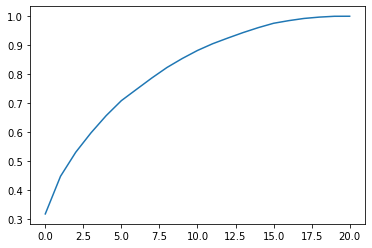

In [33]:
#explained variance depending on the number of components
pca = PCA(n_components=None)
pca.fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [37]:
pca = PCA(n_components=0.9)
kf = KFold(n_splits = 10)
indexes = kf.split(X, y)
pca.fit(X_std)
X_r = pca.transform(X_std)
print('Reduced space has dimension: ', pca.n_components_)

Reduced space has dimension:  12
